In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from scipy.interpolate import LinearNDInterpolator
from mawkutils.render import prettify


RAW_DATA_PATH = Path.cwd().parent / 'data'/ 'input' / 'Diff_Inductances_Data.csv'
save_fig_cfg = dict(dpi=300, bbox_inches="tight")
IMG_PATH = Path.cwd().parent / 'notebooks' / 'img'

lbl_d = {"L_dd": r"$L_\text{dd}$"}

## Scalar flux maps of a nonlinear PMSM

In [2]:
# load data set (from Anian)
init_df = pd.read_csv(RAW_DATA_PATH)
init_df

,0,0.1,0.000493775162391928,6.00429730130032e-06,3.61938671158525e-05,0.00173057863696249
0,-0.000000e+00,0.000000,0.000494,0.000006,0.000036,0.001731
1,-0.000000e+00,0.000000,0.000494,0.000006,0.000036,0.001731
2,-0.000000e+00,0.000000,0.000494,0.000006,0.000036,0.001731
3,-0.000000e+00,0.000000,0.000494,0.000006,0.000036,0.001731
4,-0.000000e+00,0.000000,0.000494,0.000006,0.000036,0.001731
...,...,...,...,...,...,...
5145,-3.133331e+01,-248.028675,0.000197,0.000033,0.000037,0.000127
5146,-2.352708e+01,-248.890491,0.000199,0.000034,0.000039,0.000126
5147,-1.569763e+01,-249.506682,0.000200,0.000036,0.000040,0.000126
5148,-7.852690e+00,-249.876640,0.000202,0.000038,0.000042,0.000126


In [13]:
init_df.describe()

,0,0.1,0.000493775162391928,6.00429730130032e-06,3.61938671158525e-05,0.00173057863696249
count,5.150000e+03,5.150000e+03,5150.000000,5150.000000,5150.000000,5150.000000
mean,-7.879839e+01,9.536449e-15,0.000262,0.000007,0.000020,0.000899
std,6.488698e+01,1.030977e+02,0.000070,0.000034,0.000036,0.000595
min,-2.500000e+02,-2.500000e+02,0.000188,-0.000076,-0.000065,0.000126
25%,-1.239177e+02,-6.465218e+01,0.000220,-0.000018,-0.000007,0.000275
50%,-6.343459e+01,0.000000e+00,0.000240,0.000007,0.000025,0.000846
75%,-2.275090e+01,6.465218e+01,0.000264,0.000030,0.000042,0.001519
max,1.530808e-14,2.500000e+02,0.000494,0.000099,0.000110,0.001784


In [12]:
# fit interpolators
target_cols = [c for c in init_df if c.startswith("L_")]
input_cols = [c for c in init_df if c.startswith("i")]
interpolators =\
    [LinearNDInterpolator(init_df.loc[:, input_cols],
                          init_df.loc[:, lbl]*1000, # in mH
                          rescale=True) 
                          for lbl in target_cols]
x, y = np.mgrid[init_df.id.min():init_df.id.max():init_df.id.unique().size*1j,
                init_df.iq.min():init_df.iq.max():init_df.iq.unique().size*1j]                       
L_maps = [interp(x, y) for interp in interpolators]

AttributeError: 'DataFrame' object has no attribute 'id'

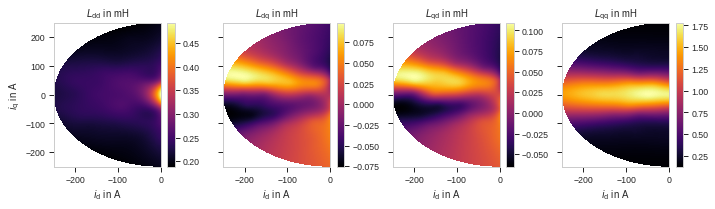

In [ ]:
# visualize with pcolormesh
fig, axes = plt.subplots(1, 4, figsize=(10, 3), sharex=True, sharey=True)

def convert_lbl(lb):
    return r'$L_\mathrm{v}$'.replace(r"v", lb.split("_")[-1]) + " in mH"

for lbl, lmap, ax in zip(target_cols, L_maps, axes.flatten()):
    p = ax.pcolormesh(x, y, lmap.reshape(x.shape), cmap="inferno", shading="auto")
    ax.set_title(convert_lbl(lbl))
    if lbl == "L_dd":
        ax.set_ylabel(r'$i_\mathrm{q}$'+" in A")
    ax.set_xlabel(r'$i_\mathrm{d}$'+" in A")
    fig.colorbar(p, ax=ax)
fig.tight_layout()

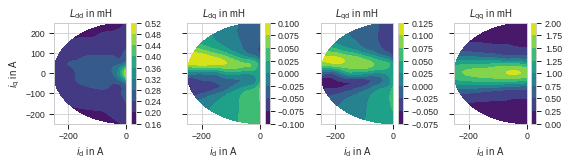

In [ ]:
# visualize with contourf
fig, axes = plt.subplots(1, 4, figsize=(8, 8*3/10), sharex=True, sharey=True)

def convert_lbl(lb):
    return r'$L_\mathrm{v}$'.replace(r"v", lb.split("_")[-1]) + " in mH"

for lbl, lmap, ax in zip(target_cols, L_maps, axes.flatten()):
    p = ax.contourf(x, y, lmap, cmap="viridis")
    ax.set_title(convert_lbl(lbl))
    if lbl == "L_dd":
        ax.set_ylabel(r'$i_\mathrm{q}$'+" in A")
    ax.set_xlabel(r'$i_\mathrm{d}$'+" in A")
    fig.colorbar(p, ax=ax)
fig.tight_layout()
fig.savefig(IMG_PATH / "1-Ldiff_pmsm.jpg", **save_fig_cfg)
fig.savefig(IMG_PATH / "1-Ldiff_pmsm.pdf", **save_fig_cfg)

## Activation functions

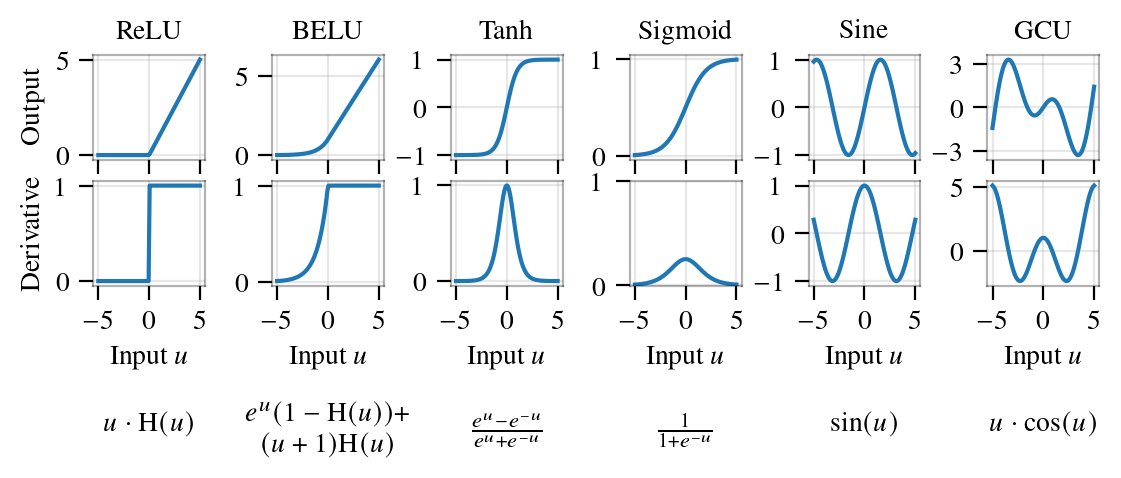

In [5]:
# plot all activation function candidates

x = np.linspace(-5, 5, 100)

acts_d = {
    'ReLU': (np.where(x >= 0, x, 0), np.where(x >= 0, 1, 0), "$u\\cdot \\mathrm{H}(u)$"),
    'BELU': (np.where(x >= 0, x+1, np.exp(x)), np.where(x >=0, 1, np.exp(x)), ['$e^u (1-\\mathrm{H}(u)) +$', '$(u+1) \\mathrm{H}(u) $']),
    'Tanh':  (np.tanh(x), 1 - np.tanh(x) * np.tanh(x), "$\\frac{e^{u} - e^{-u}}{e^{u} + e^{-u}}$"),
    'Sigmoid': ( 1/(1+np.exp(-x)), 1/(1+np.exp(-x)) * (1 - 1/(1+np.exp(-x))),"$\\frac{1}{1+e^{-u}}$"),
    'Sine': (np.sin(x), np.cos(x), "$\\mathrm{sin}(u)$"),
    'GCU': (x * np.cos(x), np.cos(x) - x* np.sin(x), '$u \\cdot \\mathrm{cos}(u)$'),
}

fig, axes = plt.subplots(2, len(acts_d), sharex=True, sharey=False, figsize=(6.49, 1.5), dpi=200)

for i, (act_name, (act_y, act_y_deriv, act_desc)) in enumerate(acts_d.items()):
    axes[0, i].plot(x, act_y)
    axes[0, i].set_title(act_name)
    axes[1, i].plot(x, act_y_deriv)
    axes[1, i].set_xlabel("Input $u$")
    if act_name == 'BELU':
        axes[1, i].text(0.5, -1.1, act_desc[0], transform=axes[1, i].transAxes, 
                    verticalalignment='top', horizontalalignment='center')
        axes[1, i].text(0.5, -1.4, act_desc[1], transform=axes[1, i].transAxes, 
                    verticalalignment='top', horizontalalignment='center')
    else:
        axes[1, i].text(0.5, -1.2, act_desc, transform=axes[1, i].transAxes, 
                        verticalalignment='top', horizontalalignment='center')
    
    if act_name == 'GCU':
        axes[0, i].set_yticks([-3, 0, 3])
    elif act_name == 'Sigmoid':
        axes[1, i].set_yticks([0, 1])
    prettify(axes[0, i])
    prettify(axes[1, i])

axes[0, 0].set_ylabel("Output")
axes[1, 0].set_ylabel("Derivative")
fig.subplots_adjust(wspace=.6)

fig.savefig(IMG_PATH / 'diss_act_funcs.pdf', dpi=160, bbox_inches='tight')